In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from generate_video import *

In [179]:
dset = gather_videos(SEQ_LEN=4, still=False, speedup=4)

In [180]:
# import os, sys
# for ii in range(100 * 100):
#     sys.stdout.write('%d/%d\r' % (ii, 3000))
#     sys.stdout.flush()
videos, masks, targets = next_video_batch(dset, bsize=32)

print(videos.shape)
print(masks.shape)
print(targets.shape)

heat1 = targets[0]
mask1 = masks[0]
video1 = videos[0]

(32, 4, 368, 368, 3)
(32, 4, 46, 46, 19)
(32, 4, 46, 46, 19)


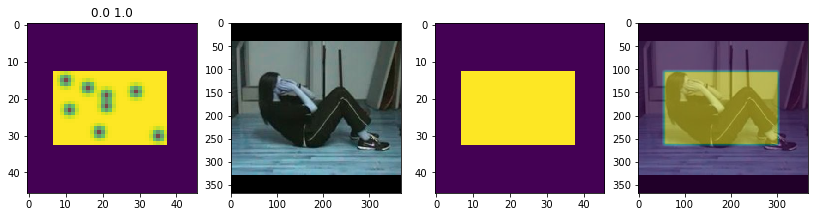

Masked out joints: [1, 14, 15, 16, 17]


In [181]:

import matplotlib.pyplot as plt



plt.figure(figsize=(14, 14))

plt.subplot(1, 4, 1)
inv = heat1[0][:,:, -1]
plt.gca().set_title('%.1f %.1f' % (np.min(inv), np.max(inv)))
plt.imshow(inv)
plt.imshow(mask1[0][:, :, -1], alpha=0.3)

plt.subplot(1, 4, 2)
plt.imshow(video1[0]/256)

plt.subplot(1, 4, 3)
plt.imshow(mask1[0][:, :, 0])

plt.subplot(1, 4, 4)
plt.imshow(video1[0]/256)
plt.imshow(cv2.resize(mask1[0][:, :, 0], (0,0), fx=8, fy=8), alpha=0.5)

plt.show()


missing = []
for ii in range(19):
    if np.max(mask1[0][:, :, ii]) == 0:
        missing.append(ii)
print('Masked out joints:', missing)

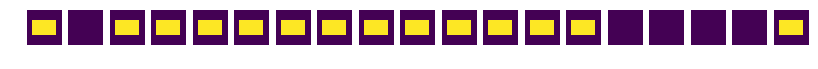

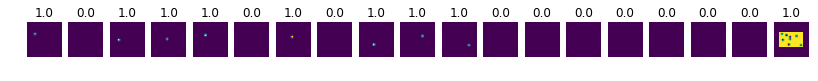

In [182]:

import matplotlib.pyplot as plt



plt.figure(figsize=(14, 14))
for ii in range(19):
    plt.subplot(1, 19, ii+1)
    plt.axis('off')
    plt.imshow(mask1[0][:, :, ii], vmin=0, vmax=1)

plt.show()

plt.figure(figsize=(14, 14))
for ii in range(19):
    plt.subplot(1, 19, ii+1)
    plt.axis('off')
    plt.gca().set_title(np.max(heat1[0][:, :, ii]))
    plt.imshow(heat1[0][:, :, ii], vmin=0, vmax=1)

plt.show()

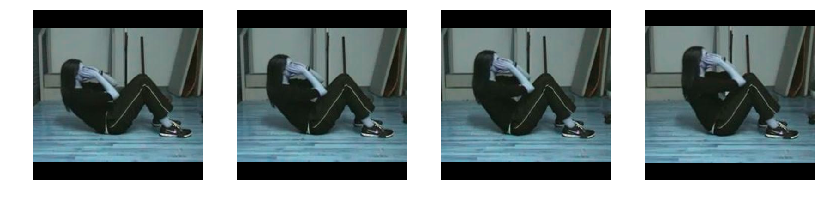

In [183]:
plt.figure(figsize=(14, 14))
for ii in range(4):
    plt.subplot(1, 4, ii+1)
    plt.axis('off')
    plt.imshow(video1[ii]/256)

plt.show()